In [1]:
# !pip install pydicom

In [2]:
# 1

import pandas as pd
import numpy as np
import Preprocess
import pydicom
import matplotlib.pyplot as plt
import cv2

## Load training labels and convert them into categorical labels
## corresponding to [0 . . . 63]

In [3]:
path = '/home/juhyeok/Documents/RSNA'
preprocess = Preprocess.Preprocess(path)

In [4]:
!ls

DataSlicing.py	model.py       __pycache__     scratch_2.ipynb	variables
Model1.py	Preprocess.py  saved_model.pb  scratch.ipynb


## Load train label stored in .csv format

In [12]:
labels = preprocess.label_set('stage_1_train.csv', 0, 600)
# labels = np.array(labels['Label'])

In [13]:
labels.head(12)

,ID,Label,Sub_type,PatientID
361025,ID_000039fa0_any,0,any,000039fa0
361020,ID_000039fa0_epidural,0,epidural,000039fa0
361021,ID_000039fa0_intraparenchymal,0,intraparenchymal,000039fa0
361022,ID_000039fa0_intraventricular,0,intraventricular,000039fa0
361023,ID_000039fa0_subarachnoid,0,subarachnoid,000039fa0
361024,ID_000039fa0_subdural,0,subdural,000039fa0
3626117,ID_00005679d_any,0,any,00005679d
3626112,ID_00005679d_epidural,0,epidural,00005679d
3626113,ID_00005679d_intraparenchymal,0,intraparenchymal,00005679d
3626114,ID_00005679d_intraventricular,0,intraventricular,00005679d


## Check if I have duplicates using PatientID column

In [50]:
new_label = labels[['Label', 'PatientID']]
ID_label = labels[['PatientID']]
count = 0
for e in ID_label.duplicated():
    if e == False:
        count += 1
print(count)

199999


## Resize training label corresponding to the training images
### we would like to keep proceeding without considering duplicates for now [10.25.2019]


In [14]:
training_labels = labels['Label']
len(training_labels)

600

In [15]:
training_labels = np.array(training_labels)
training_labels = preprocess.categorize(training_labels)
len(training_labels)

100

## Load 200,000 DICOM images

In [5]:
path_dcmFiles = '/home/juhyeok/Documents/RSNA/stage_1_train_images/*.dcm'

In [6]:
dcm_files = Preprocess.Preprocess.read_dcm_files(path_dcmFiles)

In [7]:
len(dcm_files)
# type(dcm_files)

100

## Images shape issue and one example
### we are looking for images in a shape of (512, 512); however, the given image is (464, 464)

(512, 512)
(0008, 0018) SOP Instance UID                    UI: ID_000039fa0
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_eeaf99e7'
(0020, 000d) Study Instance UID                  UI: ID_134d398b61
(0020, 000e) Series Instance UID                 UI: ID_5f8484c3e0
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000000', '-141.318451', '62.720940']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.968148', '-0.250380']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) B

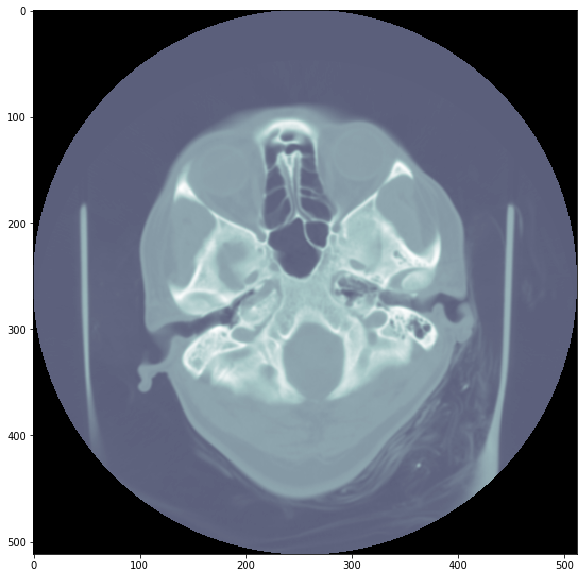

In [8]:
fig=plt.figure(figsize=(15, 10))
ds = []

# ds represents information in DICOM file
ds = pydicom.dcmread(dcm_files[0])
fig.add_subplot(1, 1, 1) # put one image into ith position of a 4 x 5 plot 
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
fig.add_subplot

print(ds.pixel_array.shape)
print(ds)

## Convert the shape of image into (256, 256) and apply three channels
### Now the converted image becomes (256, 256, 3), which is 3-Dimensional image

### will take this step for all 200,000 images. However, it will require a lot of time. We will process 2,000 images at a time right before we train over them.

### <font color='red'>WHAT I LEARNED HERE</font>
#### <font color='red'> do not have to deal with dcm.pixel_array. Instead, I can do "dcm.Pixel_Data" since it also updates pixel data (i.e., pixel_array)</font>


(0008, 0018) SOP Instance UID                    UI: ID_000039fa0
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_eeaf99e7'
(0020, 000d) Study Instance UID                  UI: ID_134d398b61
(0020, 000e) Series Instance UID                 UI: ID_5f8484c3e0
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000000', '-141.318451', '62.720940']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.968148', '-0.250380']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 256
(0028, 0011) Columns                             US: 256
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored 

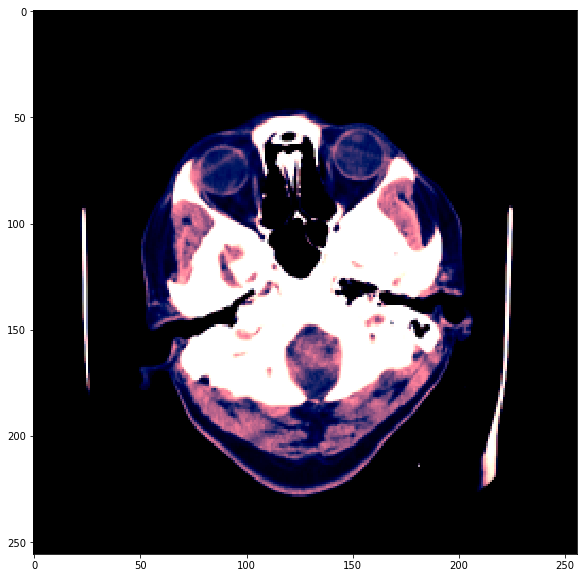

In [9]:
dcm = dcm_files[0]
metadata = pydicom.dcmread(dcm)
desired_size = (256, 256)

temp = preprocess.resizing(metadata, desired_size)
img = temp[0]
updated_metadata = temp[1]

fig=plt.figure(figsize=(15, 10))

# fig.add_subplot(rows, columns, i) 
updated_metadata.Pixel_Data = temp[0]
plt.imshow(updated_metadata.Pixel_Data, cmap=plt.cm.bone)
fig.add_subplot
    
print(updated_metadata)
print(f'type of updated_metadata: {type(updated_metadata.Pixel_Data)}')
print(f'shape of updated_metadata: {updated_metadata.Pixel_Data.shape}')
print(f'shape of img: {img.shape}')

## See if I can modify metadata using one patient example

### <font color='red'>conclusion: YES, I CAN MODIFY A METADATA</font> 
 ### <font color='red'>conclusion [updated]: not really since it only changes temporary variable "metadata". This does not mean that I changed metadata of a DICOM file.</font> 

(0008, 0018) SOP Instance UID                    UI: ID_0144e4030
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_6a01c035'
(0020, 000d) Study Instance UID                  UI: ID_056d4b375c
(0020, 000e) Series Instance UID                 UI: ID_0deb2f6b3a
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-132.3619', '-37.68413', '248.227413937099']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '0.9799283', '-0.1993503']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 256
(0028, 0011) Columns                             US: 256
(0028, 0030) Pixel Spacing                       DS: ['0.5717576', '0.5717576']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                      

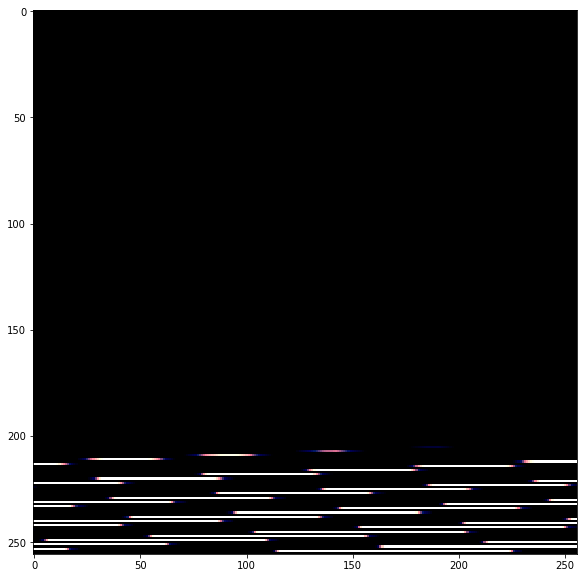

In [74]:
dcm = dcm_files[3300]
metadata = pydicom.dcmread(dcm)
desired_size = (256, 256)

# temp = preprocess.resizing(metadata, desired_size) # resizing and also apply three channels

fig=plt.figure(figsize=(15, 10))
columns = 1; rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i) 
    metadata.Pixel_Data = temp[0]
    plt.imshow(metadata.Pixel_Data, cmap=plt.cm.bone)
    fig.add_subplot


print(metadata)
print(f'type of metadata: {type(metadata.Pixel_Data)}')
print(f'shape of metadata: {metadata.Pixel_Data.shape}')

## Convert 200,000 images into a shape of (256, 256, 3) using a for loop AND modify the existing DICOM files with updated metadata

###  <font color='red'>Previously, I checked if writing a DICOM file using an already exisiting DICOM file would be possible. I changed five DICOM files and therefore, the first five DICOM files contain excess padding. It must be reprocessed again so that I will have that files valid.</font>

### <font color='blue'> It does not take that long to resize. I can resize every 2,000 pixel_array and make a training_image_set and train the model over this set. In other words, I do not have to modify all DICOM files.</font>


## <font color='blue'>The following cell is not needed anymore.</font>

In [32]:
desired_size = (256, 256)

# temporary dcm_files list so that I can test over only 5 DICOM files
# temp_dcm_files = dcm_files[:5] 
# --> These two lines of code screwed all dcm files when I ran the following codes[10/26/2019]


""" [10.26.2019] TEST WITH 20 DICOM FILES
I kept obtaining DICOM files containing the same pixel_array data. I do not know what the wrong is here.

WHAT I LEARNED is written in BLUE above.
"""
count = 0
for e in dcm_files:
    metadata = pydicom.dcmread(e)
    temp = preprocess.resizing(metadata, desired_size)
    metadata.Pixel_Data = temp[0]
    metadata = temp[1]
    pydicom.filewriter.dcmwrite(e, metadata, write_like_original=False)

type of the Pixel_Data of the corresponding metadata: <class 'numpy.ndarray'>
shape of the Pixel_Data of the corresponding metadata: (256, 256, 3)
the Pixel_Data of the corresponding metadata: [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


## Convert the original DICOM files' pixel_array into (256,256,3) and store them into a list converted_training_imgs

In [8]:
desired_size = (256, 256)

converted_training_imgs = []
converted_training_dcmData = [] # This will be used for 
for e in dcm_files:
    metadata = pydicom.dcmread(e)
    temp = preprocess.resizing(metadata, desired_size)
    converted_training_imgs.append(temp[0])
    converted_training_dcmData.append(temp[1])

In [9]:
print(f'length of the converted_training_imgs: {len(converted_training_imgs)}')
print(f'length of the converted_training_dcmData: {len(converted_training_dcmData)}')

length of the converted_training_imgs: 100
length of the converted_training_dcmData: 100


## Display first five images among converted_training_imgs

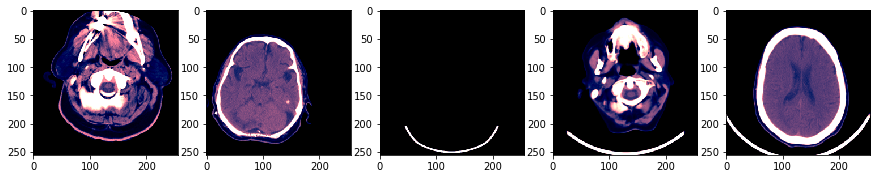

In [10]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i) 
    plt.imshow(converted_training_imgs[i], cmap=plt.cm.bone)


# plt.imshow(converted_training_imgs[3], cmap=plt.cm.bone)

## Check if the above five files contain broken image by displaying the first DICOM image

(0008, 0018) SOP Instance UID                    UI: ID_000039fa0
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_eeaf99e7'
(0020, 000d) Study Instance UID                  UI: ID_134d398b61
(0020, 000e) Series Instance UID                 UI: ID_5f8484c3e0
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000000', '-141.318451', '62.720940']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.968148', '-0.250380']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored 

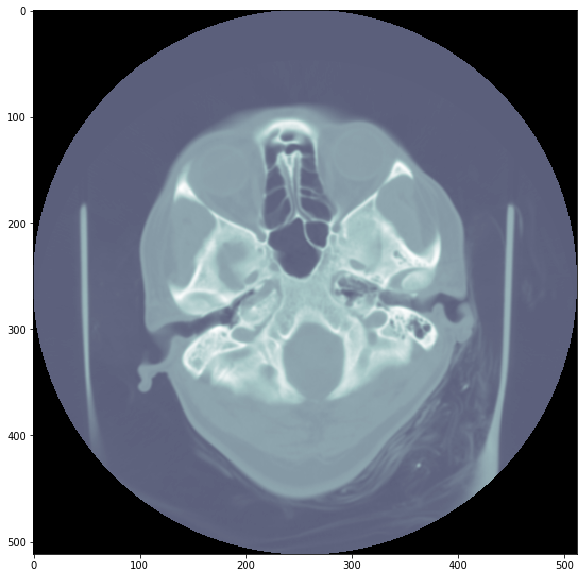

In [15]:
dcm = dcm_files[0]
metadata_1 = pydicom.dcmread(dcm)

fig=plt.figure(figsize=(15, 10))

fig.add_subplot(rows, columns, i) 
plt.imshow(metadata_1.pixel_array, cmap=plt.cm.bone)
fig.add_subplot

print(metadata_1)

(0008, 0018) SOP Instance UID                    UI: ID_000039fa0
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_eeaf99e7'
(0020, 000d) Study Instance UID                  UI: ID_134d398b61
(0020, 000e) Series Instance UID                 UI: ID_5f8484c3e0
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000000', '-141.318451', '62.720940']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.968148', '-0.250380']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored 

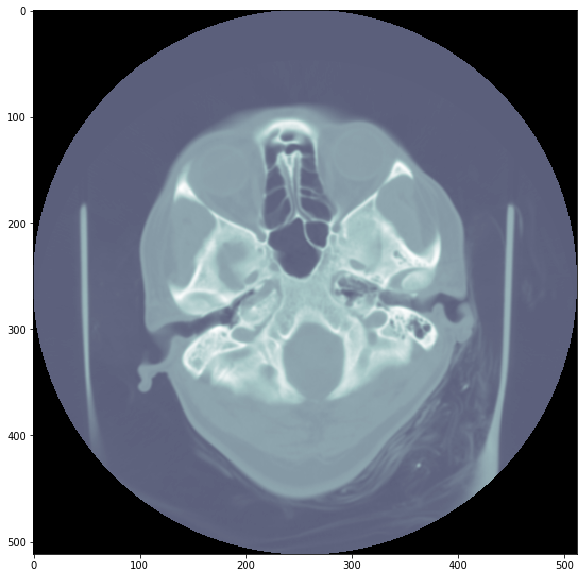

In [14]:
dcm = dcm_files[0]
metadata = pydicom.dcmread(dcm)

fig=plt.figure(figsize=(15, 10))
columns = 1; rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i) 
    metadata.Pixel_Data = temp[0]
    plt.imshow(metadata.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

print(metadata)

In [33]:
ds = pydicom.dcmread(dcm_files[0])
print(ds)

(0008, 0018) SOP Instance UID                    UI: ID_000039fa0
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_eeaf99e7'
(0020, 000d) Study Instance UID                  UI: ID_134d398b61
(0020, 000e) Series Instance UID                 UI: ID_5f8484c3e0
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000000', '-141.318451', '62.720940']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.968148', '-0.250380']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 256
(0028, 0011) Columns                             US: 256
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored 

## Check if metadata of dcm files is really modified with an example
###  <font color='red'>Conclusion: not at all since I stored modified metadata into a temporary variable, [metadata] instead of storing the modified data directly into a DICOM file</font>


In [96]:
example_dcm = dcm_files[0]
ds = pydicom.dcmread(example_dcm)
type(ds)
# print(f'A shape of a metadata of the corresponding dcm file: {ds.Pixel_Data.shape}')
print(f'A Pixel_Data of a metadata of the corresponding dcm file: {ds}')

A Pixel_Data of a metadata of the corresponding dcm file: (0008, 0018) SOP Instance UID                    UI: ID_000039fa0
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_eeaf99e7'
(0020, 000d) Study Instance UID                  UI: ID_134d398b61
(0020, 000e) Series Instance UID                 UI: ID_5f8484c3e0
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000000', '-141.318451', '62.720940']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.968148', '-0.250380']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 256
(0028, 0011) Columns                             US: 256
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Alloc

## Normalize all elements in the list, converted_training_imgs

In [11]:
training_imgs = preprocess.transform_all_pixel_arrays(converted_training_dcmData, converted_training_imgs)

In [30]:
# fig=plt.figure(figsize=(15, 10))

# fig.add_subplot(1, 1, 1) 
# plt.imshow(training_imgs[0], cmap=plt.cm.bone)
# fig.add_subplot

# print(metadata_1)
# training_imgs[0].shape
# type(training_imgs[0])
# training_labels = np.array(training_labels)
type(training_labels)

numpy.ndarray

In [31]:
len(training_labels)

100

## Model setup

In [17]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               31490176  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [32]:
model.fit(training_imgs, training_labels, epochs=2, validation_split=0.10, shuffle=True)

Train on 90 samples, validate on 10 samples
Epoch 1/2
90/90 [==============================] - 4s 46ms/sample - loss: 3.3165 - accuracy: 0.5778 - val_loss: 3.0246 - val_accuracy: 0.7000
Epoch 2/2
90/90 [==============================] - 4s 40ms/sample - loss: 1.8930 - accuracy: 0.8667 - val_loss: 4.2583 - val_accuracy: 0.7000


In [ ]:
# size = 100
# # training_images = []
# # training_labels = []

# for i in range(0, 1000, size):
#     training_labels = np.array(train_labels[i:i+size])
#     normalized = preprocess.transform_all_pixel_arrays(dcm_files[i:i+size])
# #     print(f'training_images shape before becoming np.array: {np.shape(training_images)}')
#     training_images = np.array(normalized)
#     print(f'training_images before reshape: {training_images.shape}')
# #     training_images = []
#     print()
# #     print(f'training_labels shape: {training_labels.shape}')
# #     print(type(training_images))
# #     training_images = training_images.reshape(size, 512, 512, 1)
# #     print(f'training_images after reshape: {training_images.shape}')
# #     model.fit(training_images, training_labels, epochs=1, validation_split=0.15, shuffle=True)
# #     model.save('/home/juhyeok/Documents/RSNA/RSNA', save_format='tf')
# #     model = tf.keras.models.load_model('/home/juhyeok/Documents/RSNA/RSNA')